In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use("ggplot")
%matplotlib inline

import cv2
from itertools import chain
from tqdm import tqdm_notebook,tnrange
from glob import glob
from skimage.io import imread, imshow,concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
DataPath = '/content/drive/MyDrive/Brain-MRI-LGG-Segmentation/lgg-mri-segmentation/kaggle_3m/'


dirs = []
images = []
masks = []
for dirname, _, filenames in os.walk(DataPath):
    for filename in filenames:
        if 'mask'in filename:
            dirs.append(dirname.replace(DataPath, ''))
            masks.append(filename)
            images.append(filename.replace('_mask', ''))

In [5]:
print(masks[:10], images[:10])

['TCGA_HT_A5RC_19990831_25_mask.tif', 'TCGA_HT_A5RC_19990831_14_mask.tif', 'TCGA_HT_A5RC_19990831_27_mask.tif', 'TCGA_HT_A5RC_19990831_1_mask.tif', 'TCGA_HT_A5RC_19990831_17_mask.tif', 'TCGA_HT_A5RC_19990831_23_mask.tif', 'TCGA_HT_A5RC_19990831_10_mask.tif', 'TCGA_HT_A5RC_19990831_20_mask.tif', 'TCGA_HT_A5RC_19990831_24_mask.tif', 'TCGA_HT_A5RC_19990831_12_mask.tif'] ['TCGA_HT_A5RC_19990831_25.tif', 'TCGA_HT_A5RC_19990831_14.tif', 'TCGA_HT_A5RC_19990831_27.tif', 'TCGA_HT_A5RC_19990831_1.tif', 'TCGA_HT_A5RC_19990831_17.tif', 'TCGA_HT_A5RC_19990831_23.tif', 'TCGA_HT_A5RC_19990831_10.tif', 'TCGA_HT_A5RC_19990831_20.tif', 'TCGA_HT_A5RC_19990831_24.tif', 'TCGA_HT_A5RC_19990831_12.tif']


In [6]:
len(dirs), len(images), len(masks)

(3929, 3929, 3929)

In [7]:
imagePath_df = pd.DataFrame({'directory':dirs, 'images':images,'masks':masks})

In [8]:
imagePath_df.head(9)

,directory,images,masks
0,TCGA_HT_A5RC_19990831,TCGA_HT_A5RC_19990831_25.tif,TCGA_HT_A5RC_19990831_25_mask.tif
1,TCGA_HT_A5RC_19990831,TCGA_HT_A5RC_19990831_14.tif,TCGA_HT_A5RC_19990831_14_mask.tif
2,TCGA_HT_A5RC_19990831,TCGA_HT_A5RC_19990831_27.tif,TCGA_HT_A5RC_19990831_27_mask.tif
3,TCGA_HT_A5RC_19990831,TCGA_HT_A5RC_19990831_1.tif,TCGA_HT_A5RC_19990831_1_mask.tif
4,TCGA_HT_A5RC_19990831,TCGA_HT_A5RC_19990831_17.tif,TCGA_HT_A5RC_19990831_17_mask.tif
5,TCGA_HT_A5RC_19990831,TCGA_HT_A5RC_19990831_23.tif,TCGA_HT_A5RC_19990831_23_mask.tif
6,TCGA_HT_A5RC_19990831,TCGA_HT_A5RC_19990831_10.tif,TCGA_HT_A5RC_19990831_10_mask.tif
7,TCGA_HT_A5RC_19990831,TCGA_HT_A5RC_19990831_20.tif,TCGA_HT_A5RC_19990831_20_mask.tif
8,TCGA_HT_A5RC_19990831,TCGA_HT_A5RC_19990831_24.tif,TCGA_HT_A5RC_19990831_24_mask.tif


# Image Shape

In [9]:
def print_imShape():
    idx = random.randint(0,len(dirs))

    imagePath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    print(image.shape)
    print(mask.shape)

In [10]:
for i in range(5):
    print_imShape()

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


# Plot Images

In [11]:
def plot_images():

    idx = random.randint(0,len(imagePath_df))

    imagePath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath,imagePath_df['directory'].iloc[idx],  imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    fig, axs = plt.subplots(1,3, figsize=[13,15])

    axs[0].imshow(image)
    axs[0].set_title("Brain MRI Slice")

    plt.grid(False)

    axs[1].imshow(mask)
    axs[1].set_title('Mask')

    plt.grid(False)

    axs[2].imshow(image)
    axs[2].imshow(mask, alpha=0.3)
    axs[2].set_title('MRI with mask')

    plt.grid(False)
    plt.show()

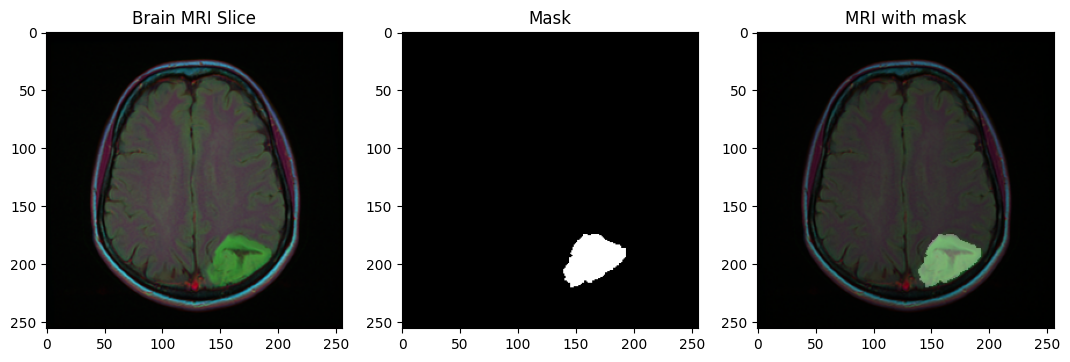

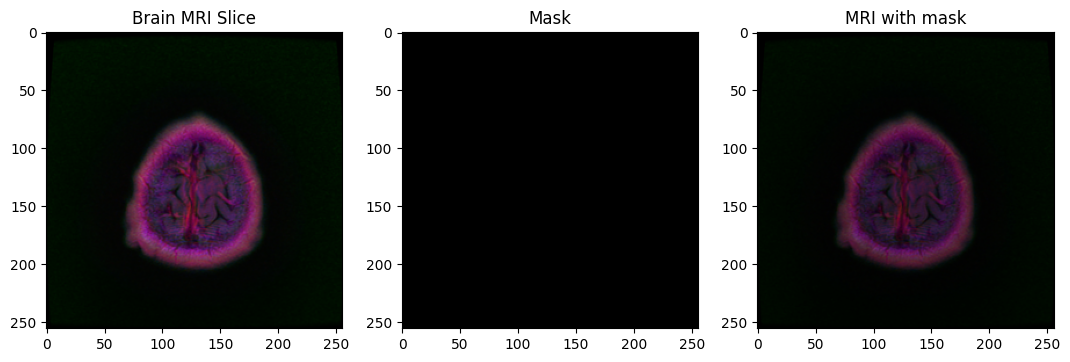

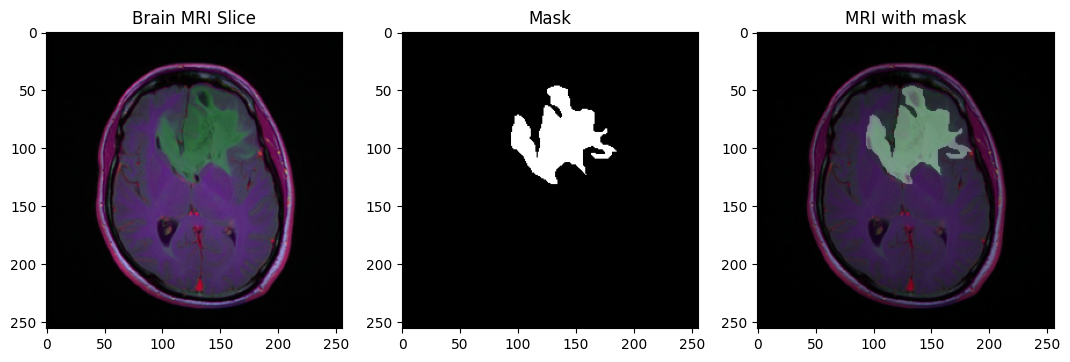

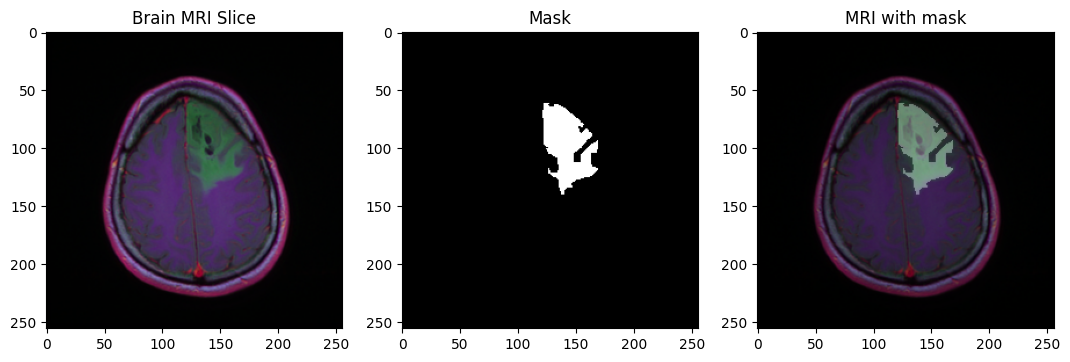

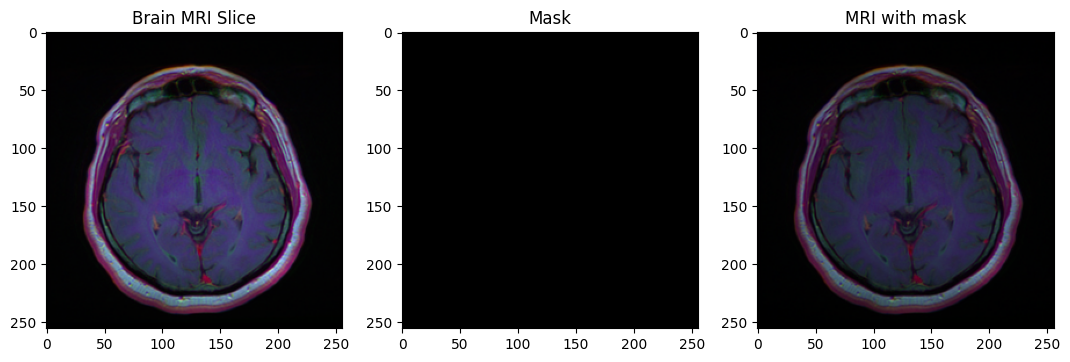

In [12]:
for i in range(5):
    plot_images()

# Config

In [13]:
imagePath_df['image-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['images']
imagePath_df['mask-path'] = DataPath + imagePath_df['directory'] + '/' + imagePath_df['masks']

In [14]:
train, test = train_test_split(imagePath_df,test_size=0.25, random_state=21)

# Play with Epochs, Batch_Size later

In [15]:
35*32 == len(images)
# len(images)

False

In [16]:
EPOCHS = 35
BATCH_SIZE = 32
ImgHeight = 256
ImgWidth = 256
Channels = 3

# Data Generator

In [17]:
data_augmentation = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest')

In [18]:
#image generator

imagegen = ImageDataGenerator(rescale=1./255., **data_augmentation)
maskgen = ImageDataGenerator(rescale=1./255., **data_augmentation)


# train generator
timage_generator=imagegen.flow_from_dataframe(dataframe=train,
                                            x_col="image-path",
                                            batch_size= BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='rgb')
# validation data generator
tmask_generator=maskgen.flow_from_dataframe(dataframe=train,
                                            x_col="mask-path",
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            class_mode=None,
                                            target_size=(ImgHeight,ImgWidth),
                                            color_mode='grayscale')

Found 2946 validated image filenames.
Found 2946 validated image filenames.


# Validation

In [19]:
# image generator
imagegen = ImageDataGenerator(rescale=1./255.)
maskgen = ImageDataGenerator(rescale=1./255.)

#train generator
vimage_generator = imagegen.flow_from_dataframe(dataframe=test,
                                             x_col = "image-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             target_size = (ImgHeight,ImgWidth),
                                             color_mode='rgb')
# validation data generator
vmask_generator = maskgen.flow_from_dataframe(dataframe=test,
                                             x_col = "mask-path",
                                             batch_size = BATCH_SIZE,
                                             seed=42,
                                             class_mode=None,
                                             target_size = (ImgHeight,ImgWidth),
                                             color_mode='grayscale')

Found 983 validated image filenames.
Found 983 validated image filenames.


In [20]:
def data_iterator(image_gen,mask_gen):
    for img, mask in zip(image_gen,mask_gen):
        yield img, mask

In [21]:
train_gen = data_iterator(timage_generator, tmask_generator)
val_gen = data_iterator(vimage_generator,vmask_generator)

## UNet
UNet is a fully convolutional neural-network. It got its name due to its U-shaped network architecture. It is currently SOTA in the sementic segmentation.

What is semenctic segmentation?

Well its a type of problem studied in computer vision just like image classification, object detection etc.

Image Classification: We Iddentify what is present in an image. If it is present or not

Object Detection: We identify what is present in the image and where it is present. Its sometimes also called object localization.

Image Segentation: In object detection we identify position of an object by labeling a bounding box. In image segmentation we assign each pixel belongs to an image or not. There are two types of Image segmentation: Sementic segmentation and Instance segmentation.following image might help a little bit to visualize difference between these two

![image.png](attachment:b4383d32-09e9-4a59-aa42-da365c35f643.png)


In [24]:
![https://drive.google.com/uc?id=1WOmTUGT_3oN_ltzWlq9ofsw9E1eJwfwH]

/bin/bash: line 1: [https://drive.google.com/uc?id=1WOmTUGT_3oN_ltzWlq9ofsw9E1eJwfwH]: No such file or directory


In [25]:
# lets create model now
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input

    # main path
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)


    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)


    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Adding the output from main path and short path together
    X = tf.keras.layers.Add()([X, X_copy])


    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = concatenate([X, skip])

    return merge


In [26]:
input_shape = (256,256,3)
X_input = Input(input_shape) #iniating tensor of input shape

# Stage 1
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
conv_1 = BatchNormalization()(conv_1)
conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
conv_1 = BatchNormalization()(conv_1)
pool_1 = MaxPooling2D((2,2))(conv_1)

# stage 2
conv_2 = resblock(pool_1, 32)
pool_2 = MaxPooling2D((2,2))(conv_2)

# Stage 3
conv_3 = resblock(pool_2, 64)
pool_3 = MaxPooling2D((2,2))(conv_3)

# Stage 4
conv_4 = resblock(pool_3, 128)
pool_4 = MaxPooling2D((2,2))(conv_4)

# Stage 5 (bottle neck)
conv_5 = resblock(pool_4, 256)

# Upsample Stage 1
up_1 = upsample_concat(conv_5, conv_4)
up_1 = resblock(up_1, 128)

# Upsample Stage 2
up_2 = upsample_concat(up_1, conv_3)
up_2 = resblock(up_2, 64)

# Upsample Stage 3
up_3 = upsample_concat(up_2, conv_2)
up_3 = resblock(up_3, 32)

# Upsample Stage 4
up_4 = upsample_concat(up_3, conv_1)
up_4 = resblock(up_4, 16)

# final output
out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

model = Model(X_input, out)

In [27]:
def iou(ytrue, ypred):
    smoothing_factor=0.1
    #y_true_f=K.flatten(y_true)
    #y_pred_f=K.flatten(y_pred)
    intersection = K.sum(ytrue*ypred)
    combined_area = K.sum(ytrue+ypred)
    union_area = combined_area - intersection
    iou = (intersection+smoothing_factor)/(union_area+smoothing_factor)
    return iou

def jac_distance(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    return -iou(y_true, y_pred)

# Dice Sorenson
def dice_coef(ytrue, ypred):
    smoothing_factor=0.1
    ytrue_f = K.flatten(ytrue)
    ypred_f = K.flatten(ypred)
    intersection = K.sum(ytrue*ypred)
    ytrue_area = K.sum(ytrue)
    ypred_area = K.sum(ypred)
    combined_area = ytrue_area + ypred_area
    dice = 2*((intersection+smoothing_factor)/(combined_area+smoothing_factor))
    return dice

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [28]:

# model = UNET(input_img, n_filters=16, dropout=0.2, batchnorm=True)
# model.compile(optimizer=Adam(), loss = "binary_crossentropy", metrics=["accuracy",tf.keras.metrics.Precision(),tf.keras.metrics.MeanIoU(num_classes=2)])
"""Θα χρησιμοποιήσουμε αυτό σε μεταγενέστερο training """
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", iou, dice_coef,tf.keras.metrics.Precision()])


In [29]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(monitor='val_loss',factor=0.1, patience=5, min_lr=1e-5, verbose=1),
    ModelCheckpoint('ResUNet-segmodel-brain-mri-v9.h5', verbose=1, save_best_only=True)
]

In [30]:
STEP_SIZE_TRAIN = timage_generator.n/BATCH_SIZE
STEP_SIZE_VALID = vimage_generator.n/BATCH_SIZE

In [31]:
results = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    callbacks=callbacks,
                    validation_data=val_gen,
                   validation_steps=STEP_SIZE_VALID)

Epoch 1/35
93/92 [==============================] - ETA: -24s - loss: 0.0601 - accuracy: 0.9812 - iou: 0.1995 - dice_coef: 0.3188 - precision: 0.2650
Epoch 1: val_loss improved from inf to 0.09047, saving model to ResUNet-segmodel-brain-mri-v9.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 3285s 36s/step - loss: 0.0601 - accuracy: 0.9812 - iou: 0.1995 - dice_coef: 0.3188 - precision: 0.2650 - val_loss: 0.0905 - val_accuracy: 0.9896 - val_iou: 0.0041 - val_dice_coef: 0.0083 - val_precision: 0.0000e+00 - lr: 0.0010
Epoch 2/35
92/92 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9931 - iou: 0.3364 - dice_coef: 0.4965 - precision: 0.8055
Epoch 2: val_loss improved from 0.09047 to 0.07263, saving model to ResUNet-segmodel-brain-mri-v9.h5
92/92 [==============================] - 117s 1s/step - loss: 0.0201 - accuracy: 0.9931 - iou: 0.3338 - dice_coef: 0.4931 - precision: 0.8055 - val_loss: 0.0726 - val_accuracy: 0.9892 - val_iou: 0.0144 - val_dice_coef: 0.0283 - val_precision: 0.3509 - lr: 0.0010
Epoch 3/35
93/92 [==============================] - ETA: -1s - loss: 0.0186 - accuracy: 0.9931 - iou: 0.3633 - dice_coef: 0.5218 - precision: 0.8013
Epoch 3: val_loss improved from 0.07263 to 0.05970, saving model to Re

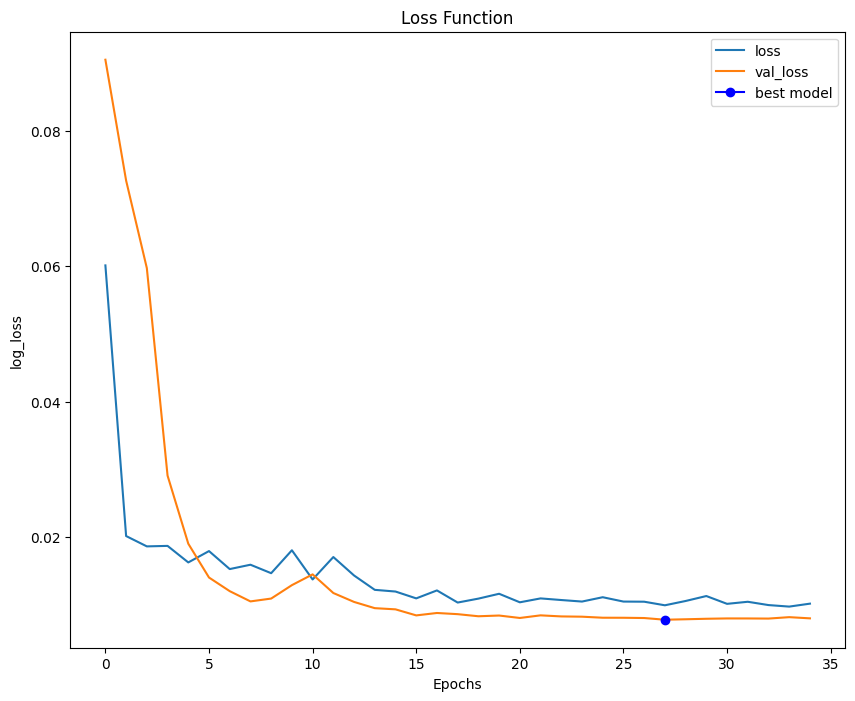

In [32]:
plt.figure(figsize=[10,8])
plt.title("Loss Function")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")

plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="o", color="b", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend()
# plt.grid(False)
plt.show()

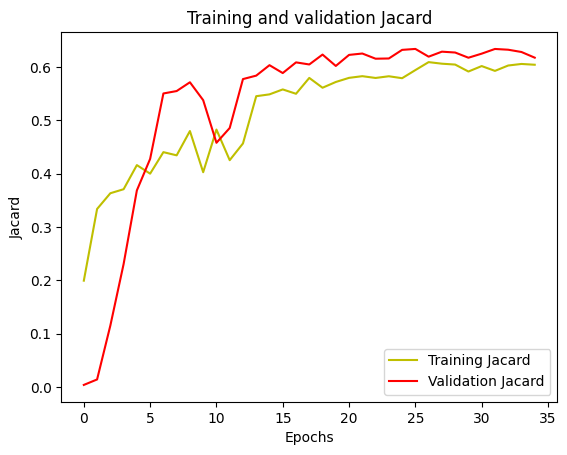

In [33]:
plt.title("Loss Function")

plt.title('Training and validation Jacard')
plt.plot(results.history["iou"], 'y', label='Training Jacard')
plt.plot(results.history['val_iou'], 'r', label='Validation Jacard')

plt.xlabel('Epochs')
plt.ylabel('Jacard')
plt.legend()
plt.show()

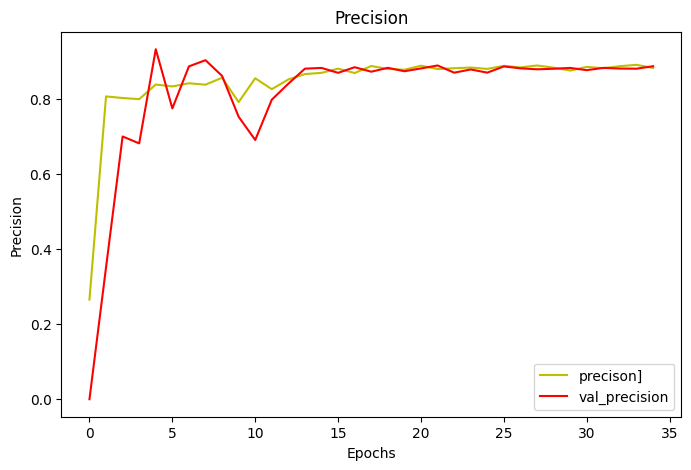

In [34]:
plt.figure(figsize=[8,5])
plt.title("Precision")
plt.plot(results.history["precision"],'y', label = "precison]")
plt.plot(results.history["val_precision"], 'r', label='val_precision')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()
# plt.grid(False)
plt.show()

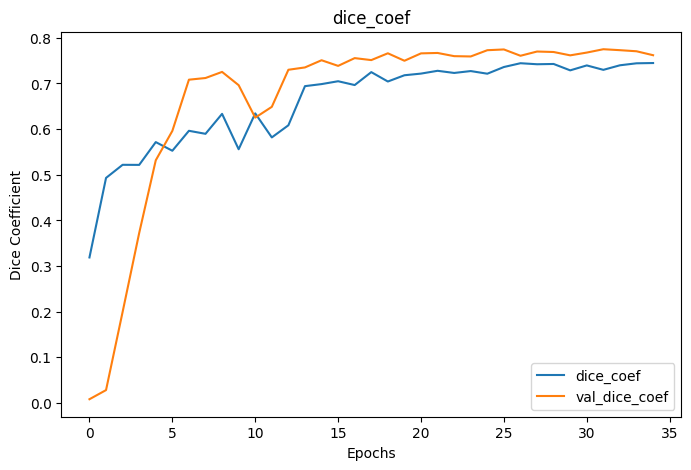

In [35]:
plt.figure(figsize=[8,5])
plt.title("dice_coef")
plt.plot(results.history["dice_coef"], label = "dice_coef")
plt.plot(results.history["val_dice_coef"], label = "val_dice_coef")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
# plt.grid(False)
plt.show()

# Prediction

In [36]:
model.load_weights('ResUNet-segmodel-brain-mri-v9.h5')
# model =models.load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [37]:
eval_results = model.evaluate(val_gen, steps=STEP_SIZE_VALID, verbose=1)

30/30 [==============================] - 12s 392ms/step - loss: 0.0077 - accuracy: 0.9972 - iou: 0.6291 - dice_coef: 0.7707 - precision: 0.8748


# Prediction Visualization

1/1 [==============================] - 2s 2s/step


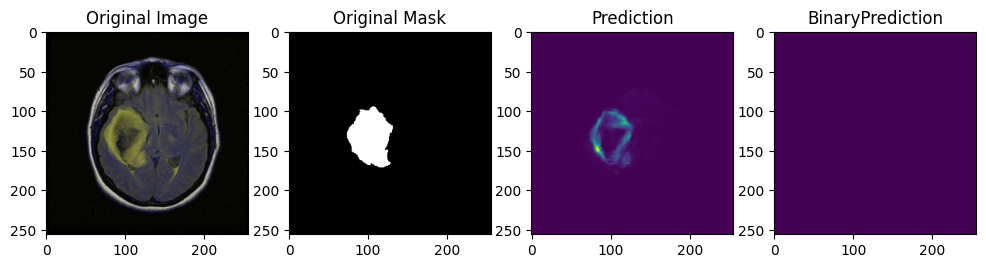

1/1 [==============================] - 0s 24ms/step


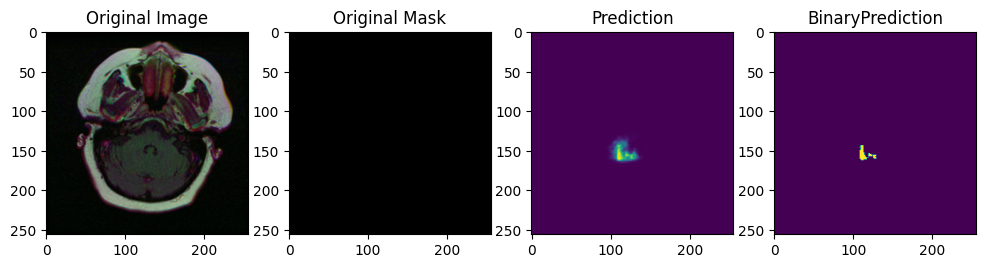

1/1 [==============================] - 0s 29ms/step


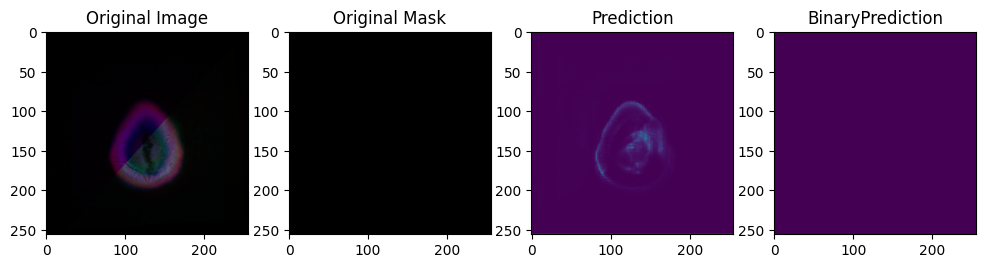

1/1 [==============================] - 0s 30ms/step


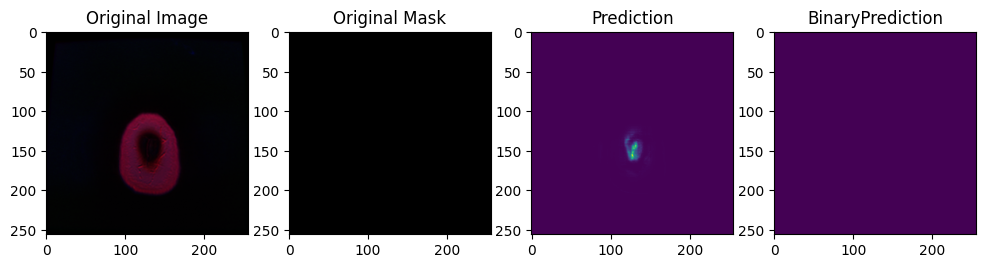

1/1 [==============================] - 0s 38ms/step


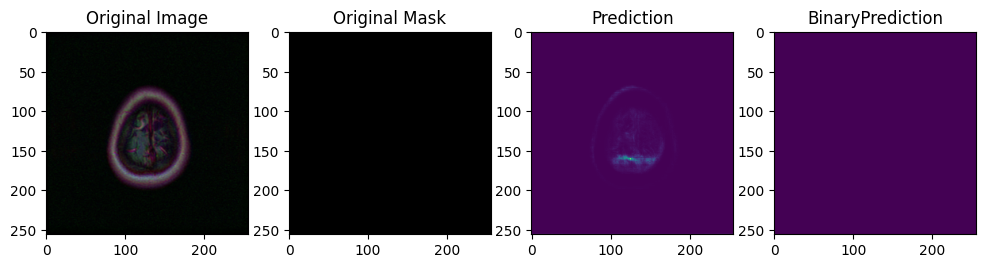

1/1 [==============================] - 0s 53ms/step


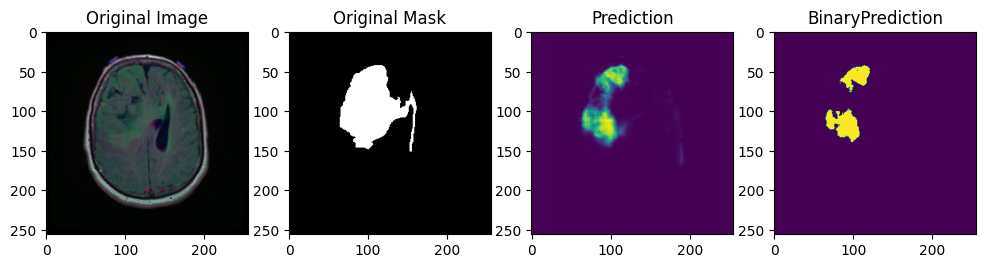

1/1 [==============================] - 0s 44ms/step


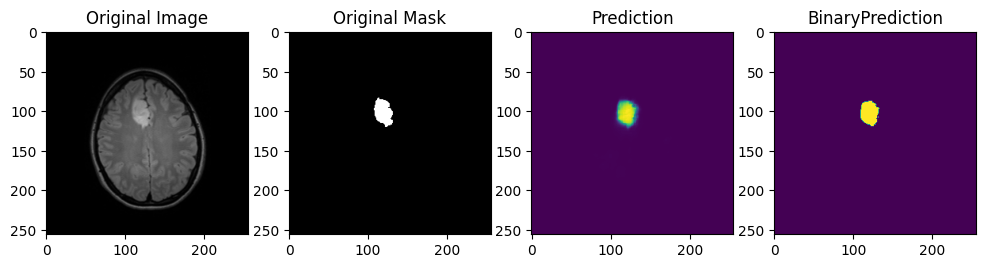

1/1 [==============================] - 0s 25ms/step


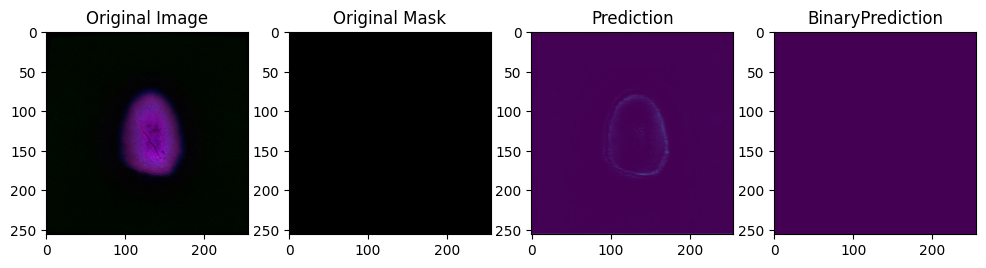

1/1 [==============================] - 0s 26ms/step


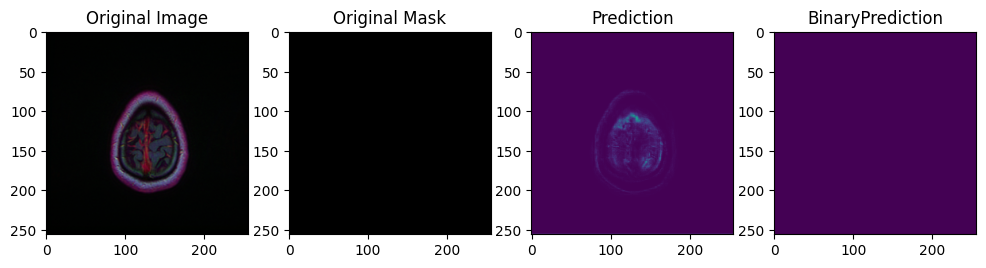

1/1 [==============================] - 0s 24ms/step


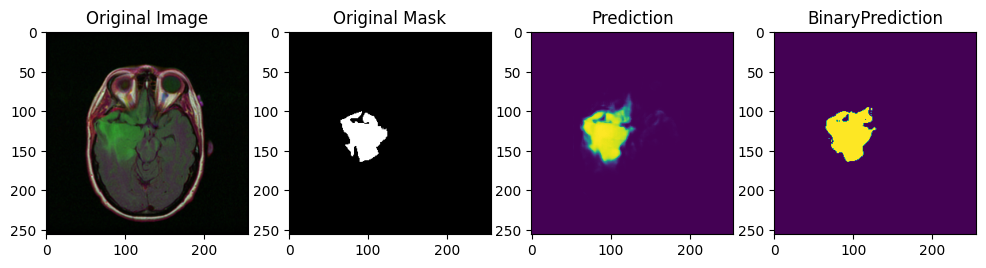

In [38]:
for i in range(10):
    idx = random.randint(0,len(imagePath_df))

    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])

    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)

    img = cv2.resize(image,(ImgHeight,ImgWidth))
    img = img/255
    img = img[np.newaxis,:,:,:]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(np.squeeze(pred) > 0.5)
    plt.title('BinaryPrediction')
    plt.show()

In [39]:
def intersection_mats(mask, bpred):

    intersection = np.sum(np.logical_and(mask,bpred))

    union = np.sum(np.logical_or(mask,bpred))
#     smooth = .00001
    mask_sum = (np.sum(np.abs(mask)) + np.sum(np.abs(bpred)))

    print(mask_sum)
    iou = (intersection) / (union)
    dice = 2 * ((intersection)/(mask_sum))

    iou = np.mean(iou)
    dice = np.mean(dice)
    iou = round(iou,2)
    dice = round(dice,2)


#     dice2 = (2*tp)/(2*tp+fp+fn)
    return iou,dice

In [40]:
from sklearn.metrics import accuracy_score,confusion_matrix

def confusion_matrs(mask,bpred):

    mask = mask.flatten()
    bpred = bpred.flatten()

    a = confusion_matrix(mask, bpred)

    return a
# return accu,a

In [46]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np

def plots():
    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
    plt.imshow(np.squeeze(img),cmap = plt.cm.gray)
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(mask)
    plt.title('Original Mask')
    plt.subplot(1,4,3)
    plt.imshow(np.squeeze(pred), cmap = plt.cm.gray)
    plt.title('Prediction')
    plt.subplot(1,4,4)
    plt.imshow(bpred,cmap = plt.cm.gray)
    plt.title('BinaryPrediction')
    plt.show()
    print("Pred Shape :",np.squeeze(pred).shape )

def prints():
    print("Mask Shape :",mask.shape )
    print("Pred after squeeze Shape :",pred.shape)
    print("Mask After rgb2gray Shape :",mask.shape )

In [50]:
#     print("Mask Values:", mask )
#     0-1
#     print("Pred Values:", pred )
#    probabilities
Iou = np.array([], dtype=np.float64)
Dice = np.array([], dtype=np.float64)
index = np.array([], dtype=int)
accuracy = np.array([], dtype=int)
precision = np.array([], dtype=int)
Sens=np.array([], dtype=np.float64)
Spec=np.array([], dtype=np.float64)
# Dice2=np.array([], dtype=np.float64)

for i in range(800):

    idx = random.randint(0,len(imagePath_df['directory']))
    index=np.append(index,idx)
    imagePath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['images'].iloc[idx])
    maskPath = os.path.join(DataPath, imagePath_df['directory'].iloc[idx], imagePath_df['masks'].iloc[idx])



    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    img = cv2.resize(image,(ImgHeight,ImgWidth))
    img = img/255
    img = img[np.newaxis,:,:,:]
#     print("Image Shape :",img.shape )

    """The first dimension is the batch size. If you are feeding 1 image at a time you can simply make the first dimension 1 and
    it doesn't change your data any, just changes the indexing to 4"""
    pred = model.predict(img)

#     pred = np.asarray(pred)
    bpred = np.array(np.squeeze(pred) > 0.5,dtype = np.uint8)

#     Visualize images

    mask = np.asarray(mask) #(1,256, 256, 3)
    mask = np.squeeze(np.squeeze(mask))#(256, 256, 3)\
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask=mask/255

    pred = np.squeeze(pred)
    bpred = np.asarray(bpred) #(256, 256)
    #Make a binary prediction
    pred = cv2.normalize(pred, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
    #     pred = cv2.cvtColor(pred, cv2.COLOR_BGR2GRAY)

#     plots()

    iou,dice = intersection_mats(mask, bpred)

    Iou = np.append(Iou, iou)
    Dice = np.append(Dice,dice)


    a =  confusion_matrs(mask,bpred)

    if np.size(a)==1:

        accu=0;
        pre=0;
        sens=0;
        spec=1;

    else:


        TN = a[0][0];
        FN = a[1][0];
        TP = a[1][1];
        FP = a[0][1];


        pre = (TP)/(TP+FP+0.001)
        accu = (TP+TN)/(TN+TP+FP+FN+0.001)
        sens = (TP)/(TP+FN)
        spec = (TN)/(TN+FP)

        accu =round(accu,2)
        pre = round(pre,2)
        sens = round(sens,2)
        spec = round(spec,2)
        print(TP,FN,TN,FP)


    accuracy = np.append(accuracy,accu)
    precision = np.append(precision,pre)
    Spec = np.append(Spec,spec)
    Sens = np.append(Sens,sens)


#     print("confusion matrix:",a)

#     Dice2 = np.append(Dice2,dice2)
#     prints()

1/1 [==============================] - 0s 44ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 33ms/step
1021.0
0 0 64515 1021
1/1 [==============================] - 0s 38ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


3894.0
1853 93 63495 95
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
960.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


111 720 64687 18
1/1 [==============================] - 0s 22ms/step
1555.0
704 74 64685 73
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
5810.0
2818 45 62544 129
1/1 [==============================] - 0s 22ms/step
495.0
0 495 65041 0
1/1 [==============================] - 0s 21ms/step
55.0
0 0 65481 55
1/1 [==============================] - 0s 22ms/step
614.0
0 0 64922 614


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
1216.0
549 80 64869 38


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 24ms/step
7894.0
3774 59 61416 287


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
36.0
0 0 65500 36
1/1 [==============================] - 0s 23ms/step
570.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


0 570 64966 0
1/1 [==============================] - 0s 23ms/step
82.0
0 0 65454 82
1/1 [==============================] - 0s 22ms/step
443.0
0 0 65093 443


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 24ms/step
96.0
0 0 65440 96
1/1 [==============================] - 0s 21ms/step
4329.0
1913 456 63120 47


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 26ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
3220.0
1533 64 63849 90
1/1 [==============================] - 0s 22ms/step
5503.0
2526 346 62559 105
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 61ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 41ms/step
0.0
1/1 [==============================] - ETA: 0s

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 41ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 40ms/step
0.0
1/1 [==============================] - ETA: 0s

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 39ms/step
1805.0
122 1366 63853 195
1/1 [==============================] - 0s 41ms/step
3487.0
1326 626 63375 209
1/1 [==============================] - 0s 34ms/step
312.0
0 0 65224 312
1/1 [==============================] - 0s 36ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


8516.0
4105 77 61125 229
1/1 [==============================] - 0s 35ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 53ms/step
5043.0
2123 40 62616 757
1/1 [==============================] - 0s 40ms/step
2780.0
945 868 63701 22
1/1 [==============================] - 0s 47ms/step
0.0
1/1 [==============================] - 0s 38ms/step
4444.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1823 749 62915 49
1/1 [==============================] - 0s 42ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 39ms/step
797.0
0 0 64739 797
1/1 [==============================] - 0s 38ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


7465.0
3166 301 61237 832
1/1 [==============================] - 0s 36ms/step
0.0
1/1 [==============================] - 0s 22ms/step
1569.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


610 331 64577 18
1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
1771.0
769 70 64534 163


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
752.0
0 752 64784 0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 22ms/step
893.0
258 342 64901 35


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 20ms/step
2034.0
799 100 64301 336


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 25ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 30ms/step
0.0
1/1 [==============================] - 0s 21ms/step
13141.0
6337 267 58732 200


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
7136.0
3293 155 61693 395


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
6975.0
2945 160 61506 925
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 28ms/step
10770.0
5101 126 59867 442


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 25ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
636.0
0 620 64900 16
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
11157.0
3806 3461 58185 84


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 28ms/step
3118.0
733 346 63151 1306
1/1 [==============================] - 0s 35ms/step
0.0
1/1 [==============================] - 0s 37ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 32ms/step
0.0
1/1 [==============================] - 0s 33ms/step
3120.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1424 63 63840 209
1/1 [==============================] - 0s 36ms/step
4816.0
1049 2718 61769 0
1/1 [==============================] - 0s 33ms/step
6256.0
2402 365 61682 1087
1/1 [==============================] - 0s 39ms/step
0.0
1/1 [==============================] - 0s 39ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1152.0
420 11 64804 301
1/1 [==============================] - 0s 41ms/step
0.0
1/1 [==============================] - ETA: 0s

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 44ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 40ms/step
0.0
1/1 [==============================] - 0s 37ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


2352.0
1045 39 64229 223
1/1 [==============================] - 0s 31ms/step
1607.0
247 1095 64176 18
1/1 [==============================] - 0s 48ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 48ms/step
1212.0
0 0 64324 1212
1/1 [==============================] - 0s 40ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


2263.0
979 207 64252 98
1/1 [==============================] - 0s 21ms/step
671.0
0 0 64865 671
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 26ms/step
8232.0
3936 123 61240 237
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
4930.0
2223 236 62829 248


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
280.0
0 0 65256 280
1/1 [==============================] - 0s 21ms/step
941.0
336 45 64931 224


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 36ms/step
2034.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


799 100 64301 336
1/1 [==============================] - 0s 40ms/step
0.0
1/1 [==============================] - 0s 35ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 43ms/step
489.0
197 67 65244 28
1/1 [==============================] - 0s 40ms/step
4095.0
1428 1202 62869 37
1/1 [==============================] - 0s 36ms/step
751.0
0 0 64785 751
1/1 [==============================] - 0s 36ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


3638.0
1528 20 63426 562
1/1 [==============================] - 0s 34ms/step
0.0
1/1 [==============================] - 0s 36ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


2748.0
1187 87 63975 287
1/1 [==============================] - 0s 37ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 50ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 42ms/step
1365.0
0 1242 64171 123
1/1 [==============================] - 0s 40ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 39ms/step
4862.0
1953 43 62627 913
1/1 [==============================] - 0s 43ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 48ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
4768.0
1837 1015 62605 79
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
1993.0
285 1415 63828 8


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
14.0
0 0 65522 14
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 21ms/step
445.0
0 0 65091 445


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 31ms/step
154.0
0 0 65382 154


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
610.0
0 0 64926 610


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 21ms/step
156.0
0 156 65380 0
1/1 [==============================] - 0s 21ms/step
1.0
0 0 65535 1
1/1 [==============================] - 0s 22ms/step
2381.0
601 914 63756 265


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 29ms/step
0.0
1/1 [==============================] - 0s 21ms/step
286.0
0 0 65250 286


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 22ms/step
2967.0
1363 58 63932 183
1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
2347.0
1084 91 64273 88


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 21ms/step
655.0
170 192 65051 123


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
11244.0
5352 59 59644 481
1/1 [==============================] - 0s 21ms/step
4831.0
1838 1114 62543 41
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
11431.0
5302 557 59407 270


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
4816.0
2121 57 62841 517
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
1155.0
446 18 64827 245
1/1 [==============================] - 0s 21ms/step
7701.0
3501 343 61336 356
1/1 [==============================] - 0s 21ms/step
2449.0
1073 138 64160 165
1/1 [==============================] - 0s 23ms/step
3322.0
1161 86 63375 914
1/1 [==============================] - 0s 21ms/step
2865.0
1025 813 63696 2
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 20ms/step
1382.0
45 1292 64199 0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
5521.0
2572 131 62587 246
1/1 [==============================] - 0s 21ms/step
198.0
0 198 65338 0
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
14.0
0 0 65522 14


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
9858.0
4674 256 60352 254
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
2366.0
746 842 63916 32


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
117.0
0 0 65419 117
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 21ms/step
8765.0
3680 1219 60451 186


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
130.0
0 0 65406 130
1/1 [==============================] - 0s 21ms/step
80.0
0 0 65456 80


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 26ms/step
4542.0
1578 275 62572 1111
1/1 [==============================] - 0s 36ms/step
0.0
1/1 [==============================] - 0s 36ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0
1/1 [==============================] - 0s 44ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


100.0
0 0 65436 100
1/1 [==============================] - 0s 44ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


4930.0
2223 236 62829 248
1/1 [==============================] - 0s 44ms/step
1313.0
0 0 64223 1313
1/1 [==============================] - 0s 42ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0
1/1 [==============================] - 0s 40ms/step
0.0
1/1 [==============================] - ETA: 0s

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 41ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 40ms/step
1478.0
285 860 64343 48
1/1 [==============================] - 0s 54ms/step
0.0
1/1 [==============================] - ETA: 0s

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 35ms/step
1255.0
0 0 64281 1255
1/1 [==============================] - 0s 45ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


6445.0
2936 462 62027 111
1/1 [==============================] - 0s 42ms/step
0.0
1/1 [==============================] - 0s 40ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 44ms/step
60.0
0 60 65476 0
1/1 [==============================] - 0s 39ms/step
0.0
1/1 [==============================] - 0s 21ms/step
8746.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


4169 220 60959 188
1/1 [==============================] - 0s 22ms/step
2803.0
1250 109 63983 194
1/1 [==============================] - 0s 21ms/step
1363.0
142 1020 64315 59
1/1 [==============================] - 0s 21ms/step
2943.0
1400 26 63993 117
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 24ms/step
1185.0
433 9 64784 310


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
953.0
240 0 64823 473


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
596.0
0 0 64940 596
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
7972.0
3870 152 61434 80
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
7509.0
3335 32 61362 807


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
11.0
0 0 65525 11
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 26ms/step
4110.0
1668 284 63094 490
1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 23ms/step
1079.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


468 37 64925 106
1/1 [==============================] - 0s 22ms/step
1899.0
363 21 64000 1152
1/1 [==============================] - 0s 22ms/step
315.0
0 0 65221 315
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
2620.0
317 1986 63233 0
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 24ms/step
3622.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


217 717 62131 2471
1/1 [==============================] - 0s 23ms/step
4244.0
1426 5 62718 1387
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 36ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 25ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
6493.0
2695 486 61738 617
1/1 [==============================] - 0s 27ms/step
7894.0
3440 126 61082 888
1/1 [==============================] - 0s 25ms/step
8787.0
812 803 57561 6360
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 31ms/step
6058.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


2242 548 61720 1026
1/1 [==============================] - 0s 22ms/step
15.0
0 0 65521 15
1/1 [==============================] - 0s 23ms/step
3122.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1096 215 63510 715
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
778.0
0 0 64758 778


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 27ms/step
658.0
0 0 64878 658
1/1 [==============================] - 0s 24ms/step
36.0
0 0 65500 36


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 23ms/step
10485.0
4800 783 59851 102
1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 22ms/step
3680.0
1136 923 62992 485


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
9359.0
4112 1038 60289 97
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
1788.0
786 163 64534 53
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
1124.0
409 115 64821 191


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 33ms/step
445.0
0 0 65091 445
1/1 [==============================] - 0s 40ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


3378.0
1391 437 63549 159
1/1 [==============================] - 0s 43ms/step
0.0
1/1 [==============================] - 0s 35ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 32ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 33ms/step
4759.0
1791 72 62568 1105
1/1 [==============================] - 0s 41ms/step
6594.0
3073 76 62015 372
1/1 [==============================] - 0s 40ms/step
6146.0
2898 76 62288 274
1/1 [==============================] - 0s 38ms/step
0.0
1/1 [==============================] - 0s 31ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 44ms/step
140.0
0 0 65396 140
1/1 [==============================] - 0s 34ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


37.0
0 37 65499 0
1/1 [==============================] - 0s 38ms/step
0.0
1/1 [==============================] - 0s 33ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 37ms/step
281.0
0 0 65255 281
1/1 [==============================] - 0s 37ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0
1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
540.0
147 118 65143 128


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
8977.0
3639 1526 60198 173
1/1 [==============================] - 0s 21ms/step
146.0
47 45 65437 7
1/1 [==============================] - 0s 20ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
2701.0
1172 33 64007 324
1/1 [==============================] - 0s 23ms/step
2745.0
954 688 63745 149
1/1 [==============================] - 0s 24ms/step
2263.0
979 207 64252 98
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
59.0
0 59 65477 0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
3487.0
1326 626 63375 209
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 24ms/step
445.0
0 0 65091 445


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
1212.0
0 0 64324 1212


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 23ms/step
4087.0
1975 41 63424 96
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
1.0
0 0 65535 1
1/1 [==============================] - 0s 22ms/step
536.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


0 536 65000 0
1/1 [==============================] - 0s 22ms/step
5873.0
2804 142 62467 123
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
3521.0
1485 411 63500 140


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
10781.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


5060 85 59815 576
1/1 [==============================] - 0s 24ms/step
7928.0
3682 244 61290 320
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
8107.0
3483 884 60912 257


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
3198.0
1369 1 63707 459
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
2593.0
1149 22 64092 273


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
2203.0
918 254 64251 113
1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
344.0
0 0 65192 344
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 25ms/step
9055.0
3449 1054 59930 1103


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
5497.0
2384 578 62423 151


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
6817.0
2662 116 61381 1377


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 25ms/step
460.0
0 0 65076 460
1/1 [==============================] - 0s 22ms/step
1303.0
296 6 64529 705


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
3107.0
1035 914 63464 123
1/1 [==============================] - 0s 22ms/step
144.0
0 0 65392 144
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 22ms/step
6975.0
2945 160 61506 925


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 31ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
3115.0
1477 62 63898 99
1/1 [==============================] - 0s 45ms/step
0.0
1/1 [==============================] - ETA: 0s

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 40ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 36ms/step
204.0
0 204 65332 0
1/1 [==============================] - 0s 43ms/step
4097.0
867 2315 62306 48
1/1 [==============================] - 0s 47ms/step
2435.0
1090 8 64191 247
1/1 [==============================] - 0s 44ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 38ms/step
8073.0
2652 2401 60115 368
1/1 [==============================] - 0s 46ms/step
2876.0
1377 70 64037 52
1/1 [==============================] - 0s 44ms/step
4488.0
1750 902 62798 86
1/1 [==============================] - 0s 40ms/step
2617.0
969 183 63888 496
1/1 [==============================] - 0s 35ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 45ms/step
1447.0
376 24 64465 671
1/1 [==============================] - 0s 37ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 49ms/step
38.0
0 0 65498 38
1/1 [==============================] - 0s 54ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


4097.0
867 2315 62306 48
1/1 [==============================] - 0s 37ms/step
1086.0
447 66 64897 126
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
2850.0
1244 347 63930 15


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
4831.0
1838 1114 62543 41


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
1143.0
492 125 64885 34
1/1 [==============================] - 0s 21ms/step
916.0
0 916 64620 0
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
712.0
0 712 64824 0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
1935.0
736 8 64337 455
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
73.0
0 0 65463 73


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 23ms/step
4732.0
1864 782 62668 222
1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 34ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 23ms/step
2570.0
252 35 63218 2031


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 21ms/step
7894.0
3774 59 61416 287


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
2814.0
1299 84 64021 132
1/1 [==============================] - 0s 22ms/step
5357.0
2462 155 62641 278
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 25ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
2388.0
0 0 63148 2388


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
903.0
265 373 64898 0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
3472.0
1643 43 63707 143
1/1 [==============================] - 0s 31ms/step
0.0
1/1 [==============================] - 0s 21ms/step
4555.0
2055 274 63036 171


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
1763.0
597 535 64370 34
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
1993.0
285 1415 63828 8


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
79.0
0 79 65457 0
1/1 [==============================] - 0s 26ms/step
2780.0
945 868 63701 22
1/1 [==============================] - 0s 23ms/step
73.0
0 0 65463 73
1/1 [==============================] - 0s 20ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 28ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 24ms/step
464.0
0 0 65072 464


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 36ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 21ms/step
3174.0
1282 578 63644 32


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 24ms/step
6963.0
2996 887 61569 84


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 23ms/step
4816.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


2121 57 62841 517
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
1363.0
142 1020 64315 59
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
7314.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


828 5631 59050 27
1/1 [==============================] - 0s 31ms/step
0.0
1/1 [==============================] - 0s 39ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1989.0
886 22 64433 195
1/1 [==============================] - 0s 44ms/step
464.0
0 0 65072 464
1/1 [==============================] - 0s 36ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


3044.0
1418 93 63910 115
1/1 [==============================] - 0s 39ms/step
2521.0
915 608 63930 83
1/1 [==============================] - 0s 37ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 59ms/step
1153.0
532 45 64915 44
1/1 [==============================] - 0s 41ms/step
0.0
1/1 [==============================] - 0s 35ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 42ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 45ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 45ms/step
0.0
1/1 [==============================] - 0s 34ms/step
2708.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1161 21 63989 365
1/1 [==============================] - 0s 50ms/step
0.0
1/1 [==============================] - ETA: 0s

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 42ms/step
0.0
1/1 [==============================] - ETA: 0s

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 45ms/step
0.0
1/1 [==============================] - 0s 24ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


4049.0
1432 1182 62919 3
1/1 [==============================] - 0s 23ms/step
2627.0
1141 106 64050 239
1/1 [==============================] - 0s 23ms/step
8179.0
3487 440 60844 765
1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
23.0
0 23 65513 0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 21ms/step
3917.0
1736 65 63355 380


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
10553.0
4935 211 59918 472
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
9987.0
4117 553 59666 1200


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
2003.0
771 282 64304 179
1/1 [==============================] - 0s 22ms/step
1038.0
0 0 64498 1038
1/1 [==============================] - 0s 23ms/step
97.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


0 0 65439 97
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
108.0
0 0 65428 108


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 22ms/step
10.0
0 0 65526 10
1/1 [==============================] - 0s 27ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
11853.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


3697 3291 57380 1168
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
2328.0
999 187 64207 143
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
4984.0
2224 342 62776 194
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
28.0
0 0 65508 28
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 21ms/step
2988.0
1124 13 63672 727


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
2908.0
0 0 62628 2908
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
429.0
0 0 65107 429


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 23ms/step
6819.0
1199 4419 59916 2
1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
42.0
0 0 65494 42
1/1 [==============================] - 0s 21ms/step
3107.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1035 914 63464 123
1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
2279.0
906 316 64163 151
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 24ms/step
7747.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


2600 1740 60389 807
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 23ms/step
1903.0
832 64 64465 175


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 24ms/step
3528.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1280 104 63288 864
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 27ms/step
3.0
0 0 65533 3


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
962.0
0 0 64574 962
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
60.0
0 60 65476 0
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 24ms/step
1124.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


409 115 64821 191
1/1 [==============================] - 0s 41ms/step
154.0
0 0 65382 154
1/1 [==============================] - 0s 47ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


6400.0
2464 1469 61600 3
1/1 [==============================] - 0s 40ms/step
588.0
0 588 64948 0
1/1 [==============================] - 0s 42ms/step
2089.0
463 1150 63910 13
1/1 [==============================] - 0s 47ms/step
4384.0
2089 52 63241 154
1/1 [==============================] - 0s 43ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 48ms/step
3362.0
1457 1 63631 447
1/1 [==============================] - 0s 50ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 56ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 45ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 52ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 48ms/step
1.0
0 0 65535 1
1/1 [==============================] - 0s 58ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


452.0
8 278 65092 158
1/1 [==============================] - 0s 28ms/step
5378.0
2253 12 62411 860
1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 27ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
2349.0
794 755 63981 6
1/1 [==============================] - 0s 23ms/step
2627.0
1239 131 64148 18
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
1907.0
766 279 64395 96
1/1 [==============================] - 0s 22ms/step
3412.0
1561 48 63685 242
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 25ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 25ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
1928.0
828 12 64436 260
1/1 [==============================] - 0s 23ms/step
6130.0
2923 157 62329 127
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
596.0
0 0 64940 596


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 26ms/step
7840.0
3400 1002 61096 38
1/1 [==============================] - 0s 23ms/step
7019.0
3275 167 61792 302
1/1 [==============================] - 0s 23ms/step
2906.0
1005 819 63635 77
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
2439.0
1131 75 64228 102

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))



1/1 [==============================] - 0s 23ms/step
4194.0
1426 105 62768 1237
1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 23ms/step
1788.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


786 163 64534 53
1/1 [==============================] - 0s 23ms/step
10873.0
4957 677 59620 282
1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
4822.0
2141 324 62855 216
1/1 [==============================] - 0s 23ms/step
1928.0
828 12 64436 260
1/1 [==============================] - 0s 35ms/step
950.0
367 108 64953 108
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 23ms/step
7291.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


3243 536 61488 269
1/1 [==============================] - 0s 25ms/step
251.0
0 0 65285 251
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 33ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 24ms/step
133.0
0 133 65403 0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
6594.0
3073 76 62015 372


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
1014.0
404 191 64926 15
1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
497.0
0 497 65039 0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
39.0
0 0 65497 39
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 27ms/step
11877.0
5595 260 59254 427
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
7749.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


3028 1156 60815 537
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 26ms/step
2916.0
1351 94 63971 120


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
1078.0
0 0 64458 1078
1/1 [==============================] - 0s 22ms/step
361.0
0 0 65175 361


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 32ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 38ms/step
4329.0
1913 456 63120 47
1/1 [==============================] - 0s 33ms/step
0.0
1/1 [==============================] - 0s 38ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 36ms/step
116.0
0 0 65420 116
1/1 [==============================] - 0s 60ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0
1/1 [==============================] - 0s 55ms/step
890.0
0 0 64646 890
1/1 [==============================] - 0s 46ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0
1/1 [==============================] - 0s 47ms/step
4402.0
0 0 61134 4402
1/1 [==============================] - 0s 52ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


117.0
0 0 65419 117
1/1 [==============================] - 0s 40ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


7.0
0 0 65529 7
1/1 [==============================] - 0s 43ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0
1/1 [==============================] - 0s 40ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 54ms/step
636.0
0 620 64900 16
1/1 [==============================] - 0s 39ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 44ms/step
440.0
192 48 65288 8
1/1 [==============================] - 0s 40ms/step
0.0
1/1 [==============================] - 0s 27ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 23ms/step
2034.0
799 100

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


 64301 336
1/1 [==============================] - 0s 21ms/step
2381.0
601 914 63756 265
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 26ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
988.0
393 61 64941 141
1/1 [==============================] - 0s 22ms/step
752.0
0 752 64784 0
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
1478.0
285 860 64343 48


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
2744.0
521 17 63313 1685
1/1 [==============================] - 0s 25ms/step
611.0
0 0 64925 611
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
3889.0
1834 51 63481 170
1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 21ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
5043.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


2123 40 62616 757
1/1 [==============================] - 0s 21ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 24ms/step
2524.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


402 1703 63414 17
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
42.0
0 37 65494 5


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 27ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 26ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
2695.0
1173 53 64014 296
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 35ms/step
694.0
118 458 64960 0
1/1 [==============================] - 0s 35ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 46ms/step
0.0
1/1 [==============================] - 0s 32ms/step
4816.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1049 2718 61769 0
1/1 [==============================] - 0s 33ms/step
11331.0
5226 270 59431 609
1/1 [==============================] - 0s 52ms/step
1639.0
0 0 63897 1639
1/1 [==============================] - 0s 41ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


46.0
0 0 65490 46
1/1 [==============================] - 0s 47ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0
1/1 [==============================] - 0s 43ms/step
0.0
1/1 [==============================] - 0s 33ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 37ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 39ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 54ms/step
2044.0
952 22 64444 118
1/1 [==============================] - 0s 42ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 48ms/step
6052.0
2822 47 62306 361
1/1 [==============================] - 0s 57ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 51ms/step
0.0
1/1 [==============================] - 0s 21ms/step
312.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0 0 65224 312
1/1 [==============================] - 0s 37ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 35ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 42ms/step
0.0
1/1 [==============================] - 0s 33ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 33ms/step
0.0
1/1 [==============================] - 0s 37ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 37ms/step
2034.0
799 100 64301 336
1/1 [==============================] - 0s 39ms/step
157.0
0 157 65379 0
1/1 [==============================] - 0s 37ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 37ms/step
2881.0
926 138 63581 891
1/1 [==============================] - 0s 48ms/step
6066.0
1306 3442 60776 12
1/1 [==============================] - 0s 45ms/step
2570.0
886 186 63852 612
1/1 [==============================] - 0s 52ms/step
1907.0
766 279 64395 96
1/1 [==============================] - 0s 38ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 39ms/step
5817.0
2614 78 62333 511
1/1 [==============================] - 0s 53ms/step
0.0
1/1 [==============================] - ETA: 0s

<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 49ms/step
1460.0
570 11 64646 309
1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 23ms/step
6594.0
2951 60 61893 632


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 24ms/step
918.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0 918 64618 0
1/1 [==============================] - 0s 25ms/step
6559.0
2888 168 61865 615
1/1 [==============================] - 0s 24ms/step
399.0
0 0 65137 399
1/1 [==============================] - 0s 25ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 30ms/step
2433.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1098 144 64201 93
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 24ms/step
1646.0
0 0 63890 1646


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1/1 [==============================] - 0s 23ms/step
73.0
0 0 65463 73
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
522.0
150 222 65164 0
1/1 [==============================] - 0s 23ms/step
1138.0
25 1088 64423 0
1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
2088.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


748 33 64196 559
1/1 [==============================] - 0s 24ms/step
633.0
7 619 64910 0
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 25ms/step
1512.0
371 35 64395 735
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 24ms/step
2261.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1033 183 64308 12
1/1 [==============================] - 0s 33ms/step
0.0
1/1 [==============================] - 0s 23ms/step
1966.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0 0 63570 1966
1/1 [==============================] - 0s 22ms/step
165.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


0 0 65371 165
1/1 [==============================] - 0s 28ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
1897.0
789 99 64428 220
1/1 [==============================] - 0s 22ms/step
7497.0
1718 4061 59757 0
1/1 [==============================] - 0s 25ms/step
4542.0
1578 275 62572 1111
1/1 [==============================] - 0s 24ms/step
4113.0
1977 20 63400 139
1/1 [==============================] - 0s 23ms/step
1639.0
0 0 63897 1639
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
2630.0
704 1216 63610 6
1/1 [==============================] - 0s 22ms/step
961.0
0 0 64575 961
1/1 [==============================] - 0s 22ms/step
366.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


5 356 65175 0
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 33ms/step
99.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0 99 65437 0
1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 22ms/step
2148.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


560 10 63948 1018
1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 23ms/step
1099.0
460 113 64897 66


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 22ms/step
3118.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


254 2610 62672 0
1/1 [==============================] - 0s 22ms/step
2336.0
1004 44 64204 284
1/1 [==============================] - 0s 26ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 23ms/step
803.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0 0 64733 803
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 28ms/step
921.0
314 232 64929 61
1/1 [==============================] - 0s 22ms/step
0.0
1/1 [==============================] - 0s 22ms/step
7567.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


3529 188 61498 321
1/1 [==============================] - 0s 23ms/step
2828.0
1323 51 64031 131
1/1 [==============================] - 0s 23ms/step
4287.0
1889 364 63138 145
1/1 [==============================] - 0s 37ms/step
0.0
1/1 [==============================] - 0s 34ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1605.0
560 204 64491 281
1/1 [==============================] - 0s 47ms/step
3530.0
1657 157 63663 59
1/1 [==============================] - 0s 38ms/step
0.0
1/1 [==============================] - 0s 42ms/step


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


35.0
0 0 65501 35
1/1 [==============================] - 0s 57ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0
1/1 [==============================] - 0s 38ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 59ms/step
2695.0
1173 53 64014 296
1/1 [==============================] - 0s 38ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 50ms/step
209.0
0 0 65327 209
1/1 [==============================] - 0s 35ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)


1647.0
0 0 63889 1647
1/1 [==============================] - 0s 44ms/step


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


0.0
1/1 [==============================] - 0s 51ms/step
3944.0
1650 532 63242 112
1/1 [==============================] - 0s 46ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 42ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 46ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 54ms/step
2352.0
1045 39 64229 223
1/1 [==============================] - 0s 24ms/step
903.0
265 373 64898 0
1/1 [==============================] - 0s 24ms/step
0.0
1/1 [==============================] - 0s 24ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
3118.0
254 2610 62672 0
1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 22ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 22ms/step
517.0
0 0 65019 517
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-50-f703227cfa98>:78: RuntimeWarning: invalid value encountered in scalar divide
  sens = (TP)/(TP+FN)
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 29ms/step
0.0
1/1 [==============================] - 0s 27ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 24ms/step
1705.0
719 237 64550 30
1/1 [==============================] - 0s 25ms/step
0.0
1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0
1/1 [==============================] - 0s 25ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))
<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


1/1 [==============================] - 0s 23ms/step
0.0


<ipython-input-39-06c5c33b4c23>:10: RuntimeWarning: invalid value encountered in scalar divide
  iou = (intersection) / (union)
<ipython-input-39-06c5c33b4c23>:11: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2 * ((intersection)/(mask_sum))


# Metrics

In [51]:
df = pd.DataFrame({'Jacard':Iou, 'Dice_Coef':Dice, 'Accuracy':accuracy,'Precision':precision, 'Specificity':Spec,'Sensitivity':Sens})
#
# 'Dice_Coef_2':Dice2,
df = df.dropna()
indice = df[(df['Jacard']==0)].index
df.drop(indice, inplace=True)

print("Jacard Mean: {m}. Jacard STD: {s}.".format(m = round(df['Jacard'].mean(),2) ,s = round(df['Jacard'].std(),2)))
print("Dice_Coef Mean: {m}. Dice_Coef STD: {s}.".format(m = round(df['Dice_Coef'].mean(),2),s = round(df['Dice_Coef'].std(),2)))
print("Accuracy Mean: {m}. Accuracy STD: {s}.".format(m = round(df['Accuracy'].mean(),2),s = round(df['Accuracy'].std(),2)))
print("Precision Mean: {m}. Precision STD: {s}.".format(m = round(df['Precision'].mean(),2),s = round(df['Precision'].std(),2)))
print("Specificity: {m}. Specificity STD: {s}.".format(m = round(df['Specificity'].mean(),2),s = round(df['Specificity'].std(),2)))
print("Sensitivity: {m}. Sensitivity STD: {s}.".format(m = round(df['Sensitivity'].mean(),2),s = round(df['Sensitivity'].std(),2)))


# sthlh (1-MASKA) / (0-OXI MASKA) +++ PLHROFORIA APO DATA.CSV +++
# df.to_csv("metric-results_v2.csv",index=False)
df

Jacard Mean: 0.64. Jacard STD: 0.24.
Dice_Coef Mean: 0.75. Dice_Coef STD: 0.22.
Accuracy Mean: 0.99. Accuracy STD: 0.01.
Precision Mean: 0.83. Precision STD: 0.18.
Specificity: 1.0. Specificity STD: 0.01.
Sensitivity: 0.76. Sensitivity STD: 0.27.


<ipython-input-51-c0a92fd02c27>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(indice, inplace=True)


,Jacard,Dice_Coef,Accuracy,Precision,Specificity,Sensitivity
2,0.91,0.95,1.00,0.95,1.0,0.95
4,0.13,0.23,0.99,0.86,1.0,0.13
5,0.83,0.91,1.00,0.91,1.0,0.90
8,0.94,0.97,1.00,0.96,1.0,0.98
15,0.82,0.90,1.00,0.94,1.0,0.87
...,...,...,...,...,...,...
779,0.72,0.84,0.99,0.94,1.0,0.76
783,0.80,0.89,1.00,0.82,1.0,0.96
784,0.42,0.59,0.99,1.00,1.0,0.42
787,0.09,0.16,0.96,1.00,1.0,0.09


# Boxplots

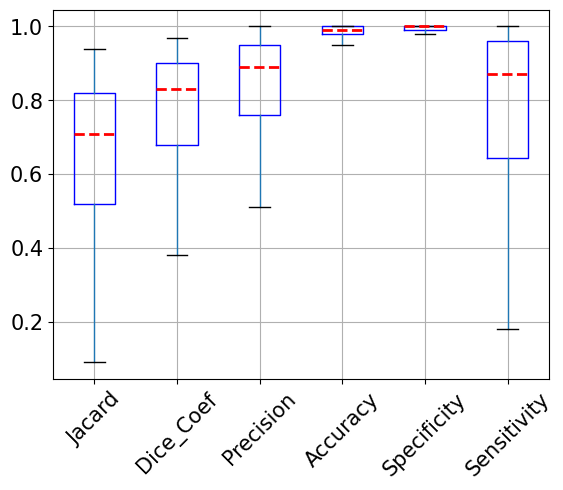

In [52]:
# Plot boxplot
boxprops = dict(linestyle='-', color='blue')
medianprops = dict(linestyle= '--',linewidth='2', color='r')
fig,ax  = plt.subplots()

boxplot = df.boxplot(column=['Jacard','Dice_Coef','Precision', 'Accuracy','Specificity','Sensitivity'],rot=45, fontsize=15,
                    medianprops=medianprops, boxprops=boxprops,showfliers=False, showmeans=False)
plt.show()